## Importing Libraries and Packages

In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from albumentations.pytorch import ToTensorV2
import albumentations as A
import torch.nn as nn
from torch.optim import Adam
from tqdm.auto import tqdm
from model import UNet
from dataset import get_images
from utils import check_accuracy

D:\work\Projects\Programming\PythonProjects\UniverInnopolis\venv\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## Loading Data

In [2]:
data_dir = ['data/Cars/data'+i+'/data'+i for i in ['A','B','C','D','E']]

In [3]:
t1 = A.Compose([
    A.Resize(160, 240),
    A.augmentations.transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
    ToTensorV2()
])

In [4]:
train_batch, test_batch = get_images(data_dir, transform=t1 ,batch_size=8)

### Visualizing Data

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


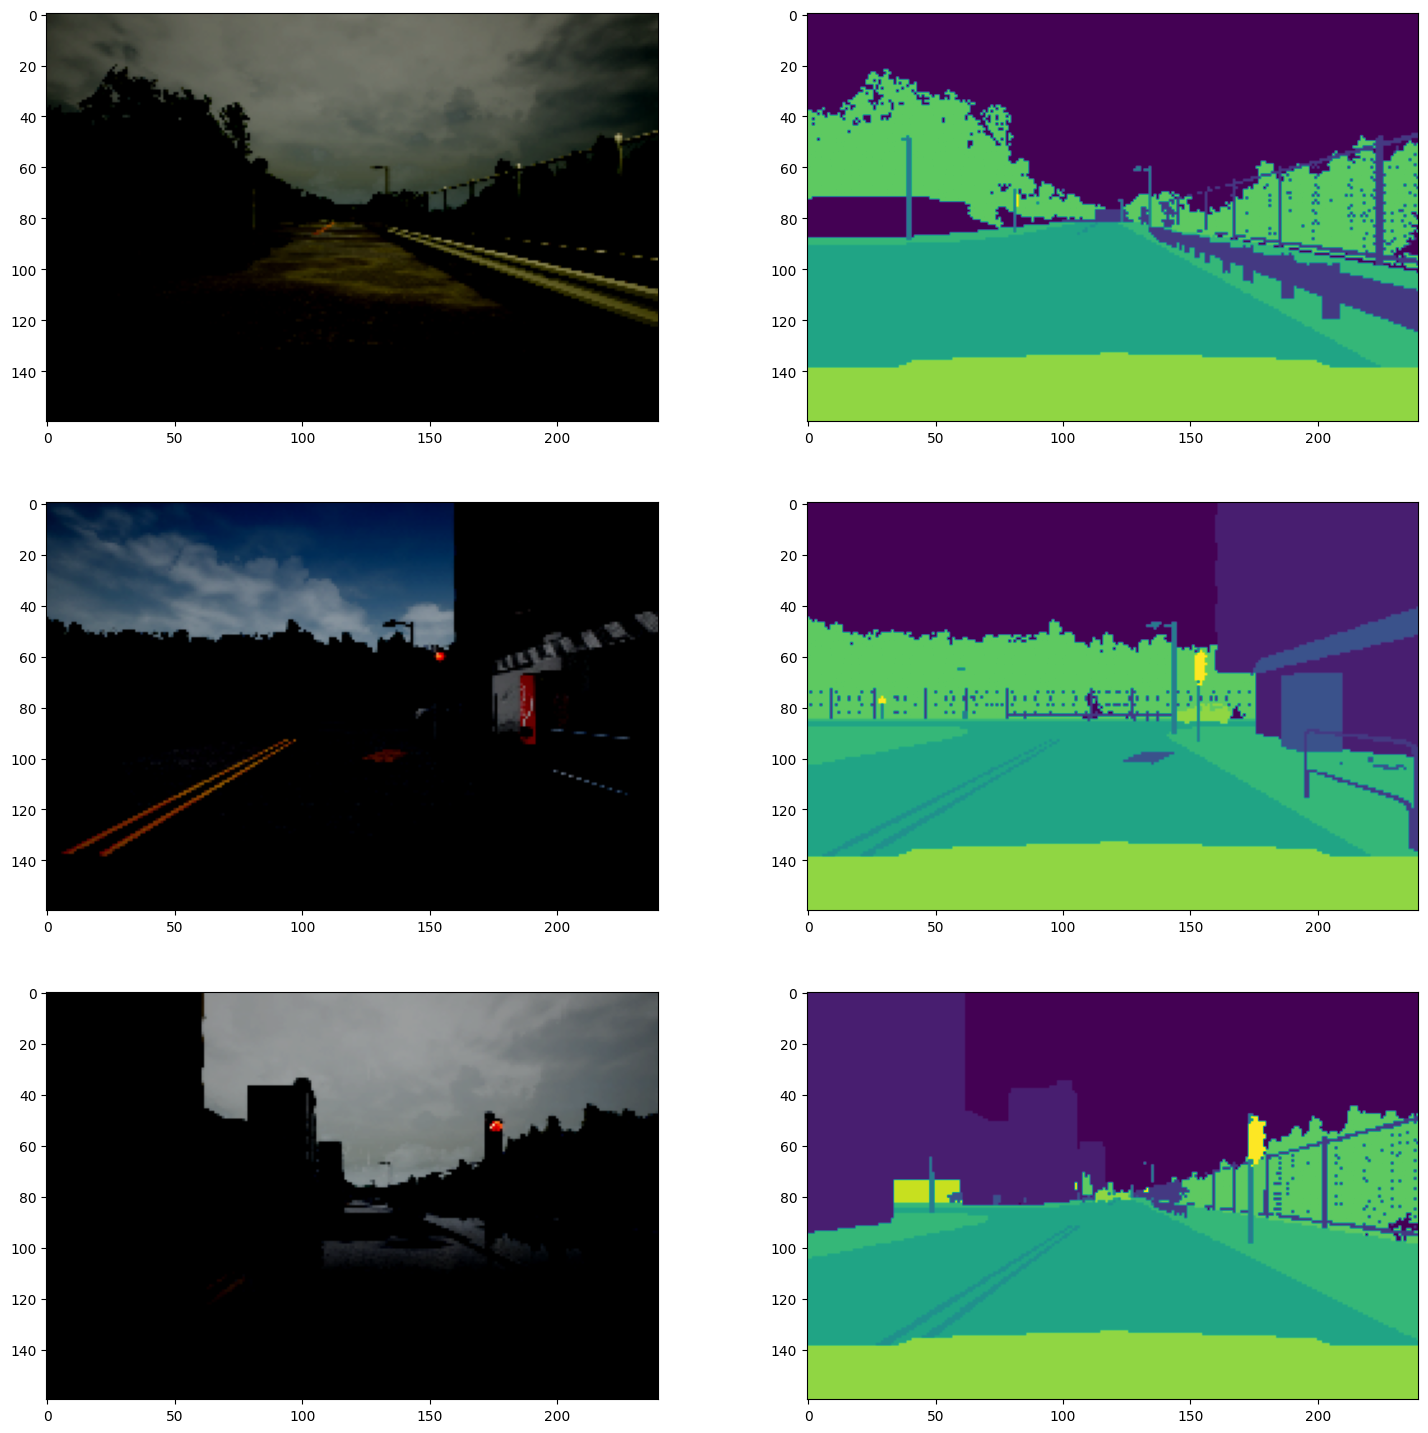

In [5]:
for img, mask in train_batch:
    fig , ax = plt.subplots(3, 2, figsize=(18, 18))
    for i in range(3):
        img_i = np.transpose(img[i,:,:,:],(1,2,0))
        mask_i = np.array(mask[i,:,:])
        ax[i][0].imshow(img_i)
        ax[i][1].imshow(mask_i)
    break

## Model Creation and Training

In [6]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
features = [(128, 256, 512, 1024, 2048), (64, 128, 256, 512, 1024), (32, 64, 128, 256, 512), (16, 32, 64, 128, 256)]
model_names = ['Large (2048)', 'Normal (1024)', 'Small (512)', 'Smaller (256)']
models = [UNet(features=feature).to(DEVICE) for feature in features]

In [7]:
LEARNING_RATE = 1e-4/2
num_epochs = 10
loss_fn = nn.CrossEntropyLoss()
scaler = torch.cuda.amp.GradScaler()

In [8]:
results = {'train':[], 'test':[]}
for model, model_name in zip(models, model_names):
    print(model_name)
    optimizer = Adam(model.parameters(), lr=LEARNING_RATE)
    for epoch in range(num_epochs):
        loop = tqdm(enumerate(train_batch),total=len(train_batch))
        for batch_idx, (data, targets) in loop:
            data = data.to(DEVICE)
            targets = targets.to(DEVICE)
            targets = targets.type(torch.long)
            # forward
            with torch.cuda.amp.autocast():
                predictions = model(data)
                loss = loss_fn(predictions, targets)
            # backward
            optimizer.zero_grad()
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            # update tqdm loop
            loop.set_postfix(loss=loss.item())
    torch.cuda.empty_cache()
    results['train'].append(check_accuracy(train_batch, model, DEVICE))
    torch.cuda.empty_cache()
    results['test'].append(check_accuracy(test_batch, model, DEVICE))
    torch.cuda.empty_cache()

Large (2048)


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Got 149606345/153600000 with acc 97.40
Dice score: 0.8605126142501831
Got 37316838/38400000 with acc 97.18
Dice score: 0.8492355942726135
Normal (1024)


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Got 149064329/153600000 with acc 97.05
Dice score: 0.834248423576355
Got 37168107/38400000 with acc 96.79
Dice score: 0.8248040676116943
Small (512)


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Got 147995897/153600000 with acc 96.35
Dice score: 0.7323698997497559
Got 36907975/38400000 with acc 96.11
Dice score: 0.7206678986549377
Smaller (256)


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Got 144889151/153600000 with acc 94.33
Dice score: 0.5592002272605896
Got 36154736/38400000 with acc 94.15
Dice score: 0.5544246435165405


## Model Evaluation and Visualization

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


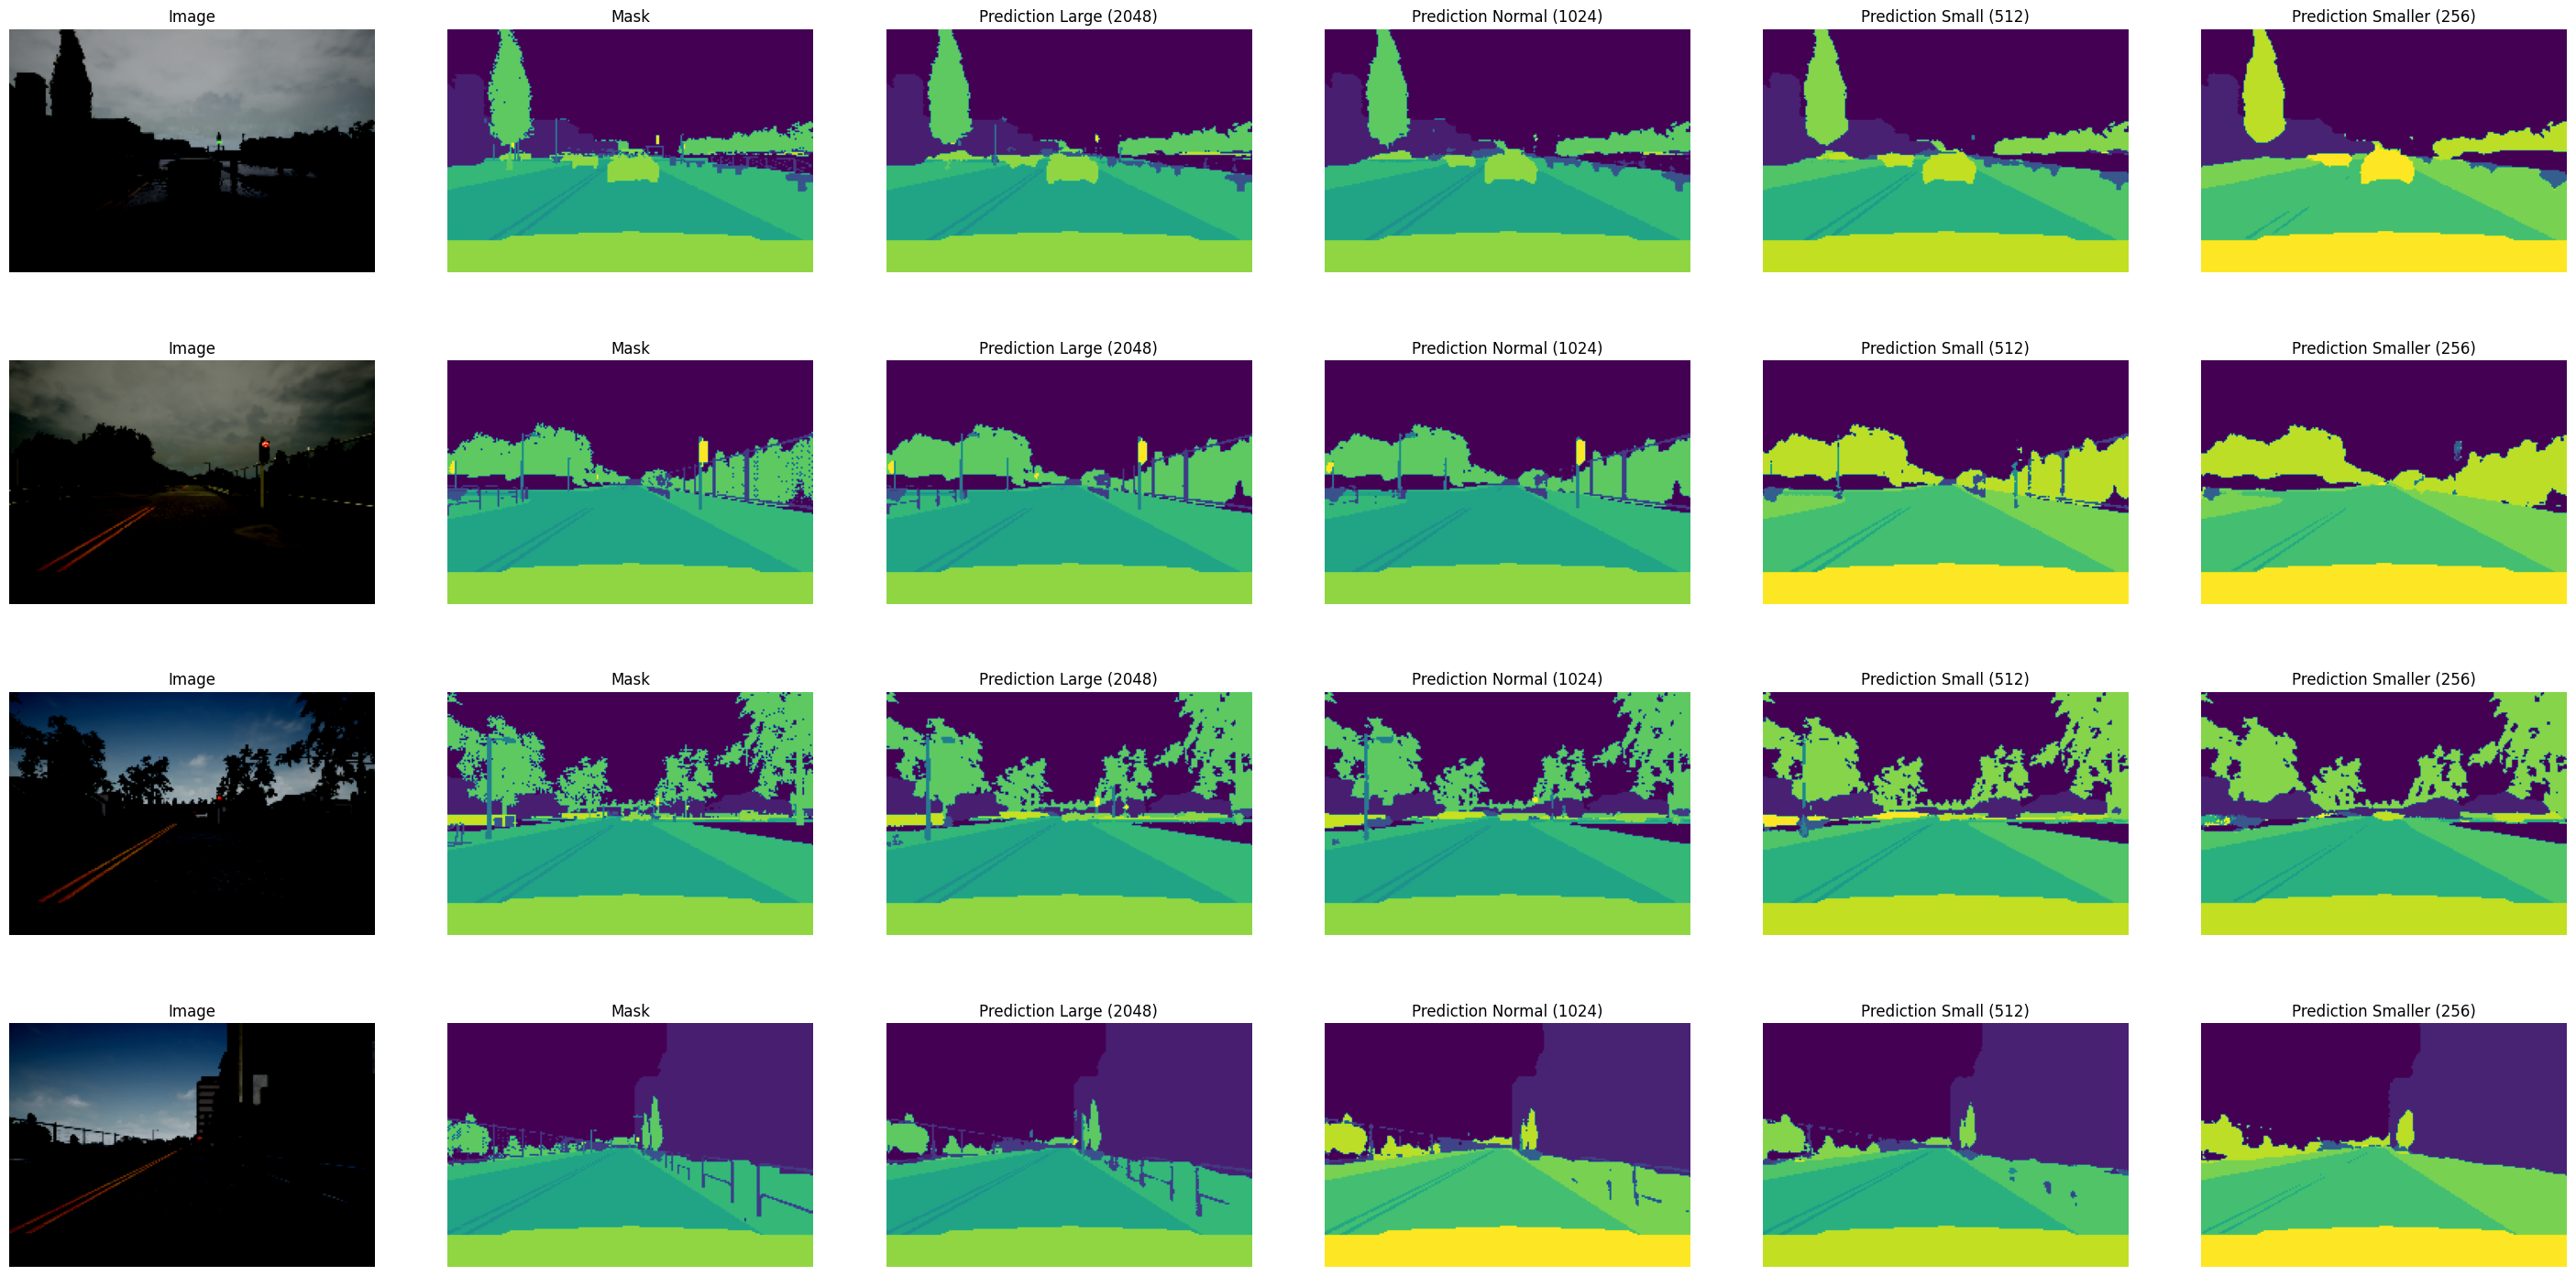

In [9]:
for x, y in test_batch:
    x = x.to(DEVICE)
    fig, ax = plt.subplots(4, 6, figsize=(36, 18))
    softmax = nn.Softmax(dim=1)
    preds = []
    for model in models:
        preds.append(torch.argmax(softmax(model(x)), axis=1).to('cpu'))

    for i in range(4):
        img = np.transpose(np.array(x[i, :, :, :].to('cpu')), (1,2,0))
        pred_ = [np.array(pred[i,:,:]) for pred in preds]
        mask = np.array(y[i,:,:])


        ax[i, 0].set_title('Image')
        ax[i, 1].set_title('Mask')
        [ax[i, j+2].set_title(f'Prediction {m_n}') for j, m_n in enumerate(model_names)]
        [ax[i][j].axis("off") for j in range(len(models) + 2)]
        ax[i][0].imshow(img)
        ax[i][1].imshow(mask)
        [ax[i][j+2].imshow(p) for j,p in enumerate(pred_)]
    break


In [10]:
torch.cuda.empty_cache()

In [11]:
acc_train = [i['acc'].item()/100 for i in results['train']]
acc_test = [i['acc'].item()/100 for i in results['test']]
dice_train = [i['dice'].item() for i in results['train']]
dice_test = [i['dice'].item() for i in results['test']]

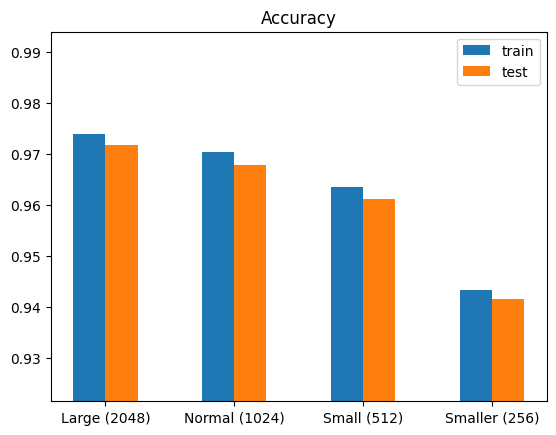

In [12]:
plt.bar(np.arange(len(models))-0.125, acc_train, width=0.5/2, label='train')
plt.bar(np.arange(len(models))+0.125, acc_test,  width=0.5/2, label='test')
plt.xticks(np.arange(len(models)), model_names)
plt.ylim(np.min([np.min(acc_train), np.min(acc_test)])-0.02, np.max([np.max(acc_train), np.max(acc_test)])+0.02)
plt.title('Accuracy')
plt.legend()
plt.show()

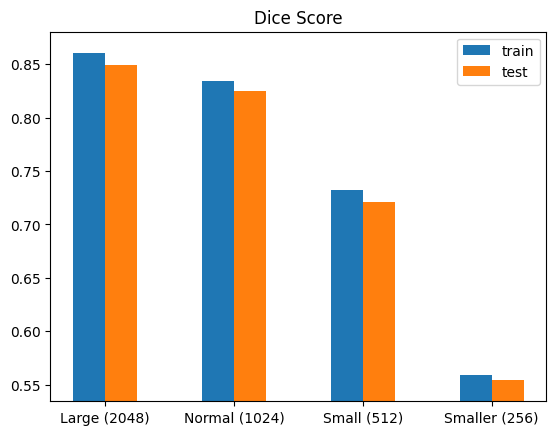

In [13]:
plt.bar(np.arange(len(models))-0.125, dice_train, width=0.5/2, label='train')
plt.bar(np.arange(len(models))+0.125, dice_test, width=0.5/2, label='test')
plt.xticks(np.arange(len(models)), model_names)
plt.ylim(np.min([np.min(dice_train), np.min(dice_test)])-0.02, np.max([np.max(dice_train), np.max(dice_test)])+0.02)
plt.title('Dice Score')
plt.legend()
plt.show()

C:\Users\sasha\AppData\Local\Temp\ipykernel_51540\3191289411.py:1: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  pytorch_total_params = [np.log10(np.sum(p.numel() for p in model.parameters())) for model in models]


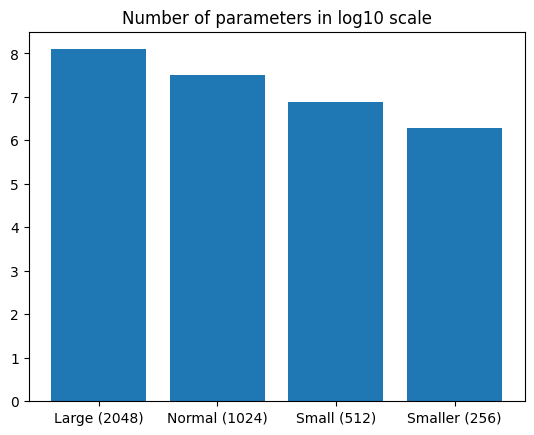

In [21]:
pytorch_total_params = [np.log10(np.sum(p.numel() for p in model.parameters())) for model in models]

plt.bar(np.arange(len(models)), pytorch_total_params)
plt.xticks(np.arange(len(models)), model_names)
plt.title('Number of parameters in log10 scale')
plt.show()

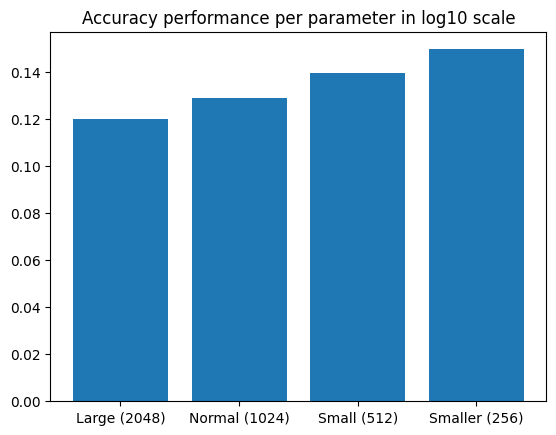

In [22]:
plt.bar(np.arange(len(models)), [d/p for d, p in zip(acc_test, pytorch_total_params)])
plt.xticks(np.arange(len(models)), model_names)
plt.title('Accuracy performance per parameter in log10 scale')
plt.show()

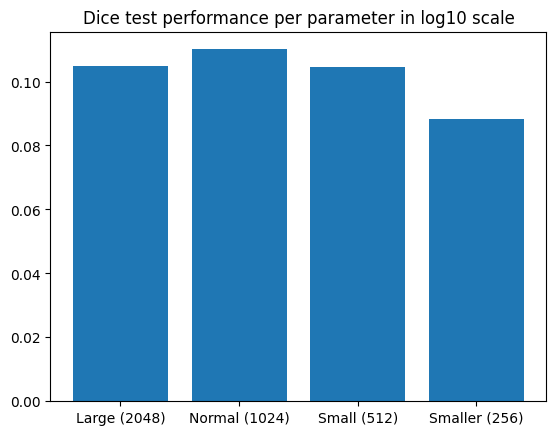

In [23]:
plt.bar(np.arange(len(models)), [d/p for d, p in zip(dice_test, pytorch_total_params)])
plt.xticks(np.arange(len(models)), model_names)
plt.title('Dice test performance per parameter in log10 scale')
plt.show()